In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np

random.seed(33)

from library.evaluation import ConfusionMatrix

unique_name = "SBERT_NLI_Mean"

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/Phemernr1_SBERT_NLI_Mean_vectors.txt", delimiter=",")
vectors.shape

(5802, 768)

In [3]:
phemernr = pd.read_csv("../../data/processed/phemernr1_dataset_with_tvt.csv", lineterminator="\n")
phemernr.head()

,tweet_text,topic,label,tvt
0,BOMBSHELL: #Ferguson chief says the police off...,ferguson,rumours,test
1,It appears that #Ferguson PD are trying to ass...,ferguson,rumours,training
2,"All weekend ppl will be talking about the ""rob...",ferguson,rumours,test
3,Why would the officer tell #MikeBrown to get o...,ferguson,rumours,test
4,Michael Brown is the 17 yr old boy who was sho...,ferguson,rumours,training


In [4]:
labels = []
for i, p2 in phemernr.iterrows():
    if p2['label'] == 'rumours':
        labels.append([0])
    elif p2['label'] == 'non-rumours':
        labels.append([1])
    else:
        labels.append(None)
labels[:10]

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]

In [5]:
train_vectors = np.array([vectors[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'training'])
val_vectors = np.array([vectors[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'validation'])
test_vectors = np.array([vectors[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'test'])

train_labels = np.array([labels[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'training'])
val_labels = np.array([labels[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'validation'])
test_labels = np.array([labels[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'test'])

In [6]:
label_tag = ['rumours', 'non-rumours']
label_tag

['rumours', 'non-rumours']

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

print("Class 0 : ", len([i for i in test_labels if i == 0]))
print("Class 1 : ", len([i for i in test_labels if i == 1]))

(3498, 768)
(1150, 768)
(1154, 768)
(3498, 1)
(1150, 1)
(1154, 1)
Class 0 :  381
Class 1 :  773


In [8]:
print(np.unique(train_labels, return_counts=True))
print(np.unique(val_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

(array([0, 1]), array([1175, 2323]))
(array([0, 1]), array([416, 734]))
(array([0, 1]), array([381, 773]))


In [9]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
#                 for i, output in enumerate(outputs.tolist()):
#                     if targets[i,0].tolist() == round(output[0]):
#                         correct += 1

#             train_acc = round(100*correct/total, 4)
#             train_accs.append(train_acc)
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                test_loss += loss.item()
                
                preds = self.predict(test_x)
                conf_mat = ConfusionMatrix(
                    labels=test_y,
                    predictions=[p[0] for p in preds.cpu().numpy()],
                    binary=True
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            return self.model(torch.Tensor(input_x))

Multiclass Classification using 4-Layer Linear Network
Using cuda
Saving after new best accuracy : 63.826
Saving after new best accuracy : 69.13
Saving after new best accuracy : 75.304
Saving after new best accuracy : 77.304
Saving after new best accuracy : 77.391
Saving after new best accuracy : 77.565
Saving after new best accuracy : 77.913
Saving after new best accuracy : 78.174
Saving after new best accuracy : 78.696
Saving after new best accuracy : 78.87
Saving after new best accuracy : 79.217
Saving after new best accuracy : 79.478
Saving after new best accuracy : 79.565
Saving after new best accuracy : 79.826
Saving after new best accuracy : 80.261
Saving after new best accuracy : 80.435
Saving after new best accuracy : 80.609
Saving after new best accuracy : 80.783
Saving after new best accuracy : 81.043
Saving after new best accuracy : 81.13
Saving after new best accuracy : 81.217
Saving after new best accuracy : 81.913
Saving after new best accuracy : 82.0
Saving after new be

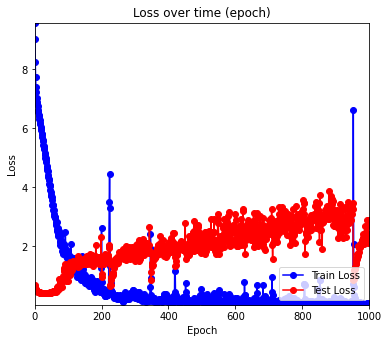

loading model from ../../data/models/Phemernr1_4LayerNet_L2Reg_SBERT_NLI_Mean.pth...

Validation Set
Predictions : torch.Size([1150, 1])
Binary Class Evaluation

True Positive : 651
False Positive : 72
False Negative : 83
True Negative : 344

Class positive Evaluation
- Precision : 90.041 %
- Recall : 88.692 %
- F1 : 0.89362

Class negative Evaluation
- Precision : 80.562 %
- Recall : 82.692 %
- F1 : 0.81613

Combined Evaluation
- Accuracy : 86.522 %
- Precision : 85.302 %
- Recall : 85.692 %
- F1 : 0.85497
- Average Confidence : 95.98 %
Model, Combined,,,,positive,,,negative,,,
Phemernr1_4LayerNet_L2Reg_SBERT_NLI_Mean, 86.522, 85.302, 85.692, 0.85497, 90.041, 88.692, 0.89362, 80.562, 82.692, 0.81613, 

Test Set
Predictions : torch.Size([1154, 1])
Binary Class Evaluation

True Positive : 678
False Positive : 73
False Negative : 95
True Negative : 308

Class positive Evaluation
- Precision : 90.28 %
- Recall : 87.71 %
- F1 : 0.88976

Class negative Evaluation
- Precision : 76.427 %
- Re

In [10]:
print("Multiclass Classification using 4-Layer Linear Network")
model_name = f"Phemernr1_4LayerNet_L2Reg_{unique_name}"
model = NNClassifier(train_vectors.shape[1], criterion=nn.BCELoss)
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=256)

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\nValidation Set")
preds = model.predict(val_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=val_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

print("\nTest Set")
preds = model.predict(test_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=test_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()